[I 2024-07-12 02:06:10,713] A new study created in memory with name: no-name-cd9ef86e-1484-452c-87b9-ffaba1b24b80
[I 2024-07-12 02:09:36,832] Trial 0 finished with value: 0.8788710816392177 and parameters: {'learning_rate': 0.24391773746536333, 'alpha': 1.0976787225350895, 'colsample_bytree': 0.5386085916749096, 'gamma': 0.05911035606830718, 'lambda': 0.0869192361790277, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.853784624822311}. Best is trial 0 with value: 0.8788710816392177.
[I 2024-07-12 02:13:00,645] Trial 1 finished with value: 0.8788854747037645 and parameters: {'learning_rate': 0.237848669518034, 'alpha': 1.165930197369206, 'colsample_bytree': 0.5685498139704006, 'gamma': 0.04515645166249685, 'lambda': 0.07150635977888987, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.7999374292606335}. Best is trial 1 with value: 0.8788854747037645.
[I 2024-07-12 02:16:34,659] Trial 2 finished with value: 0.8794804483938422 and parameters: {'learning_rate': 0.230590627083443

[0]	validation_0-logloss:0.35990
[1]	validation_0-logloss:0.34162
[2]	validation_0-logloss:0.32519
[3]	validation_0-logloss:0.31407
[4]	validation_0-logloss:0.30405
[5]	validation_0-logloss:0.29733
[6]	validation_0-logloss:0.29417
[7]	validation_0-logloss:0.28822
[8]	validation_0-logloss:0.28249
[9]	validation_0-logloss:0.28024
[10]	validation_0-logloss:0.27636
[11]	validation_0-logloss:0.27302
[12]	validation_0-logloss:0.27222
[13]	validation_0-logloss:0.26912
[14]	validation_0-logloss:0.26695
[15]	validation_0-logloss:0.26607
[16]	validation_0-logloss:0.26458
[17]	validation_0-logloss:0.26312
[18]	validation_0-logloss:0.26205
[19]	validation_0-logloss:0.26100
[20]	validation_0-logloss:0.26042
[21]	validation_0-logloss:0.26004
[22]	validation_0-logloss:0.25908
[23]	validation_0-logloss:0.25884
[24]	validation_0-logloss:0.25838
[25]	validation_0-logloss:0.25753
[26]	validation_0-logloss:0.25716
[27]	validation_0-logloss:0.25656
[28]	validation_0-logloss:0.25590
[29]	validation_0-loglos

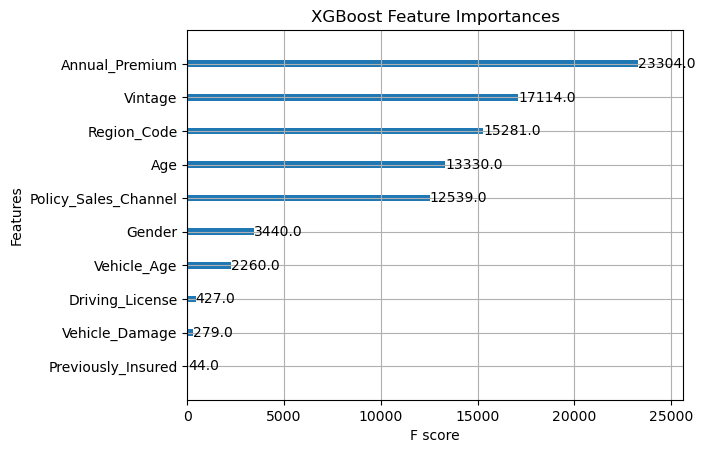

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import logging
import optuna

# Setting up the logger
logging.basicConfig(level=logging.INFO, filename='xgb_initial_search.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('initial_search')

# Create directories for storing graphs
os.makedirs('graphs_xgb_incremental', exist_ok=True)

# Load Data
train_path = "train_xgb_processed.csv"
test_path = "test_xgb_processed.csv"

logger.info("Loading datasets...")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
logger.info("Datasets loaded successfully.")
logger.info(f"Train dataset shape: {train_df.shape}")
logger.info(f"Test dataset shape: {test_df.shape}")

# Use the entire dataset
logger.info("Using the entire training data...")
X = train_df.drop('Response', axis=1)
y = train_df['Response']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the initial parameters for XGBoost
initial_params = {
    'learning_rate': 0.22787270164926926,
    'alpha': 1.0550281601606675,
    'colsample_bytree': 0.4973587910510764,
    'gamma': 0.05496827570180495,
    'lambda': 0.07917275437209338,
    'max_depth': 10,
    'min_child_weight': 3,
    'subsample': 0.9789547934268312
}

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'learning_rate': trial.suggest_float('learning_rate', initial_params['learning_rate'] * 0.8, initial_params['learning_rate'] * 1.2),
        'alpha': trial.suggest_float('alpha', initial_params['alpha'] * 0.8, initial_params['alpha'] * 1.2),
        'colsample_bytree': trial.suggest_float('colsample_bytree', max(0.0, initial_params['colsample_bytree'] * 0.8), min(1.0, initial_params['colsample_bytree'] * 1.2)),
        'gamma': trial.suggest_float('gamma', initial_params['gamma'] * 0.8, initial_params['gamma'] * 1.2),
        'lambda': trial.suggest_float('lambda', initial_params['lambda'] * 0.8, initial_params['lambda'] * 1.2),
        'max_depth': trial.suggest_int('max_depth', max(3, int(initial_params['max_depth'] * 0.8)), int(initial_params['max_depth'] * 1.2)),
        'min_child_weight': trial.suggest_int('min_child_weight', max(1, int(initial_params['min_child_weight'] * 0.8)), int(initial_params['min_child_weight'] * 1.2)),
        'subsample': trial.suggest_float('subsample', max(0.0, initial_params['subsample'] * 0.8), min(1.0, initial_params['subsample'] * 1.2))
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params, early_stopping_rounds=10)
        model.fit(X_t, y_t, eval_set=[(X_v, y_v)], verbose=False)

        y_pred = model.predict_proba(X_v)[:, 1]
        cv_scores.append(roc_auc_score(y_v, y_pred))

    return np.mean(cv_scores)

# Set up Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
logger.info(f"Best parameters from initial search: {best_params}")
logger.info(f"Best ROC AUC score from initial search: {study.best_value}")

# Save results
results_df = study.trials_dataframe()
results_df.to_csv('xgb_initial_search_results.csv', index=False)

# Train the final model with the best parameters
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

# Evaluate model performance on validation set
y_pred_val = final_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_val)
logger.info(f"Validation ROC AUC Score with best parameters: {roc_auc}")

# Save final model
final_model.save_model('final_xgb_model_initial.json')
logger.info('Final model saved to final_xgb_model_initial.json')

# Plot feature importances
xgb.plot_importance(final_model, max_num_features=10)
plt.title('XGBoost Feature Importances')
plt.savefig('graphs_xgb_incremental/xgb_feature_importances_initial.png')
plt.show()
logger.info('XGBoost feature importances plot saved.')


[I 2024-07-12 02:42:56,294] A new study created in memory with name: no-name-55128218-c859-4bc4-b498-8be56a90e8d8
[I 2024-07-12 02:46:42,974] Trial 0 finished with value: 0.8795872660880298 and parameters: {'learning_rate': 0.1964818216140643, 'alpha': 1.3214265374507903, 'colsample_bytree': 0.5128224351810001, 'gamma': 0.06557876172374676, 'lambda': 0.07043548545920313, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.8587757847031271}. Best is trial 0 with value: 0.8795872660880298.
[I 2024-07-12 02:50:19,564] Trial 1 finished with value: 0.8793696946271252 and parameters: {'learning_rate': 0.20743584965875153, 'alpha': 1.2005917255480776, 'colsample_bytree': 0.3700140576330737, 'gamma': 0.059644305858207694, 'lambda': 0.0808483331219364, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8995099823494039}. Best is trial 0 with value: 0.8795872660880298.
[I 2024-07-12 02:53:51,910] Trial 2 finished with value: 0.8788027539718642 and parameters: {'learning_rate': 0.185339159

[0]	validation_0-logloss:0.35599
[1]	validation_0-logloss:0.33595
[2]	validation_0-logloss:0.31850
[3]	validation_0-logloss:0.30707
[4]	validation_0-logloss:0.29719
[5]	validation_0-logloss:0.29073
[6]	validation_0-logloss:0.28791
[7]	validation_0-logloss:0.28239
[8]	validation_0-logloss:0.27717
[9]	validation_0-logloss:0.27520
[10]	validation_0-logloss:0.27181
[11]	validation_0-logloss:0.26890
[12]	validation_0-logloss:0.26833
[13]	validation_0-logloss:0.26588
[14]	validation_0-logloss:0.26418
[15]	validation_0-logloss:0.26344
[16]	validation_0-logloss:0.26224
[17]	validation_0-logloss:0.26107
[18]	validation_0-logloss:0.26024
[19]	validation_0-logloss:0.25945
[20]	validation_0-logloss:0.25908
[21]	validation_0-logloss:0.25873
[22]	validation_0-logloss:0.25779
[23]	validation_0-logloss:0.25759
[24]	validation_0-logloss:0.25731
[25]	validation_0-logloss:0.25659
[26]	validation_0-logloss:0.25634
[27]	validation_0-logloss:0.25597
[28]	validation_0-logloss:0.25544
[29]	validation_0-loglos

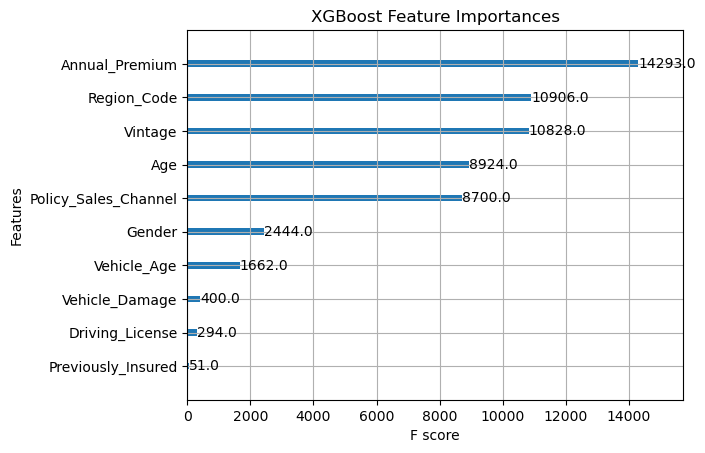

In [2]:
# Setting up the logger for intermediate search
logging.basicConfig(level=logging.INFO, filename='xgb_intermediate_search.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('intermediate_search')

# Adapt ranges based on the initial search results
best_params = {
    'learning_rate': best_params['learning_rate'],
    'alpha': best_params['alpha'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'lambda': best_params['lambda'],
    'max_depth': best_params['max_depth'],
    'min_child_weight': best_params['min_child_weight'],
    'subsample': best_params['subsample']
}

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'learning_rate': trial.suggest_float('learning_rate', best_params['learning_rate'] * 0.8, best_params['learning_rate'] * 1.2),
        'alpha': trial.suggest_float('alpha', best_params['alpha'] * 0.8, best_params['alpha'] * 1.2),
        'colsample_bytree': trial.suggest_float('colsample_bytree', max(0.0, best_params['colsample_bytree'] * 0.8), min(1.0, best_params['colsample_bytree'] * 1.2)),
        'gamma': trial.suggest_float('gamma', best_params['gamma'] * 0.8, best_params['gamma'] * 1.2),
        'lambda': trial.suggest_float('lambda', best_params['lambda'] * 0.8, best_params['lambda'] * 1.2),
        'max_depth': trial.suggest_int('max_depth', max(3, int(best_params['max_depth'] * 0.8)), int(best_params['max_depth'] * 1.2)),
        'min_child_weight': trial.suggest_int('min_child_weight', max(1, int(best_params['min_child_weight'] * 0.8)), int(best_params['min_child_weight'] * 1.2)),
        'subsample': trial.suggest_float('subsample', max(0.0, best_params['subsample'] * 0.8), min(1.0, best_params['subsample'] * 1.2))
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params, early_stopping_rounds=10)
        model.fit(X_t, y_t, eval_set=[(X_v, y_v)], verbose=False)

        y_pred = model.predict_proba(X_v)[:, 1]
        cv_scores.append(roc_auc_score(y_v, y_pred))

    return np.mean(cv_scores)

# Set up Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
logger.info(f"Best parameters from intermediate search: {best_params}")
logger.info(f"Best ROC AUC score from intermediate search: {study.best_value}")

# Save results
results_df = study.trials_dataframe()
results_df.to_csv('xgb_intermediate_search_results.csv', index=False)

# Train the final model with the best parameters
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

# Evaluate model performance on validation set
y_pred_val = final_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_val)
logger.info(f"Validation ROC AUC Score with best parameters: {roc_auc}")

# Save final model
final_model.save_model('final_xgb_model_intermediate.json')
logger.info('Final model saved to final_xgb_model_intermediate.json')

# Plot feature importances
xgb.plot_importance(final_model, max_num_features=10)
plt.title('XGBoost Feature Importances')
plt.savefig('graphs_xgb_incremental/xgb_feature_importances_intermediate.png')
plt.show()
logger.info('XGBoost feature importances plot saved.')


[I 2024-07-12 03:19:54,065] A new study created in memory with name: no-name-ea9cc938-3a86-4c71-9a45-fea3c582731c
[I 2024-07-12 03:23:40,911] Trial 0 finished with value: 0.8798430275039268 and parameters: {'learning_rate': 0.20475336340666467, 'alpha': 1.5361323355303986, 'colsample_bytree': 0.4472021612771753, 'gamma': 0.04705004749005612, 'lambda': 0.07918155149432371, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9879075176758525}. Best is trial 0 with value: 0.8798430275039268.
[I 2024-07-12 03:27:12,441] Trial 1 finished with value: 0.8789996389911802 and parameters: {'learning_rate': 0.1968635050217957, 'alpha': 1.2878134506669956, 'colsample_bytree': 0.48364194539731564, 'gamma': 0.0433300688600252, 'lambda': 0.07991418718354193, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9060835294523648}. Best is trial 0 with value: 0.8798430275039268.
[I 2024-07-12 03:30:53,249] Trial 2 finished with value: 0.8796736069511604 and parameters: {'learning_rate': 0.2312947794

[0]	validation_0-logloss:0.35758
[1]	validation_0-logloss:0.33822
[2]	validation_0-logloss:0.32103
[3]	validation_0-logloss:0.30969
[4]	validation_0-logloss:0.29973
[5]	validation_0-logloss:0.29314
[6]	validation_0-logloss:0.29018
[7]	validation_0-logloss:0.28444
[8]	validation_0-logloss:0.27892
[9]	validation_0-logloss:0.27671
[10]	validation_0-logloss:0.27312
[11]	validation_0-logloss:0.27000
[12]	validation_0-logloss:0.26934
[13]	validation_0-logloss:0.26662
[14]	validation_0-logloss:0.26469
[15]	validation_0-logloss:0.26392
[16]	validation_0-logloss:0.26261
[17]	validation_0-logloss:0.26134
[18]	validation_0-logloss:0.26043
[19]	validation_0-logloss:0.25954
[20]	validation_0-logloss:0.25911
[21]	validation_0-logloss:0.25873
[22]	validation_0-logloss:0.25786
[23]	validation_0-logloss:0.25766
[24]	validation_0-logloss:0.25732
[25]	validation_0-logloss:0.25655
[26]	validation_0-logloss:0.25626
[27]	validation_0-logloss:0.25581
[28]	validation_0-logloss:0.25523
[29]	validation_0-loglos

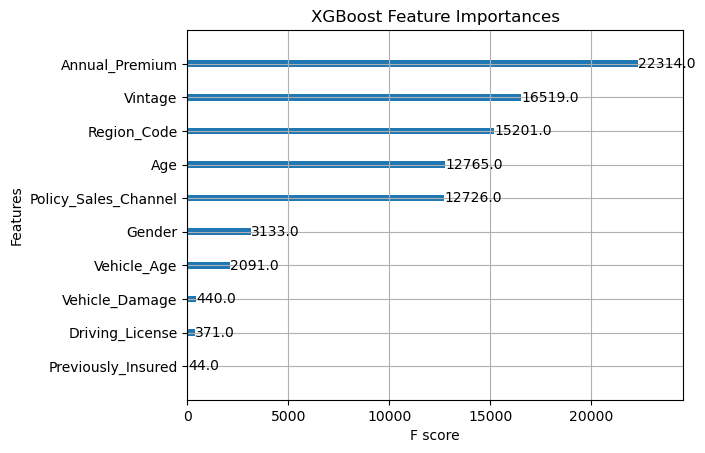

In [3]:
# Setting up the logger for fine-tuned search
logging.basicConfig(level=logging.INFO, filename='xgb_fine_tuned_search.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('fine_tuned_search')

# Adapt ranges based on the intermediate search results
best_params = {
    'learning_rate': best_params['learning_rate'],
    'alpha': best_params['alpha'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'lambda': best_params['lambda'],
    'max_depth': best_params['max_depth'],
    'min_child_weight': best_params['min_child_weight'],
    'subsample': best_params['subsample']
}

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'learning_rate': trial.suggest_float('learning_rate', best_params['learning_rate'] * 0.9, best_params['learning_rate'] * 1.1),
        'alpha': trial.suggest_float('alpha', best_params['alpha'] * 0.9, best_params['alpha'] * 1.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', max(0.0, best_params['colsample_bytree'] * 0.9), min(1.0, best_params['colsample_bytree'] * 1.1)),
        'gamma': trial.suggest_float('gamma', best_params['gamma'] * 0.9, best_params['gamma'] * 1.1),
        'lambda': trial.suggest_float('lambda', best_params['lambda'] * 0.9, best_params['lambda'] * 1.1),
        'max_depth': trial.suggest_int('max_depth', max(3, int(best_params['max_depth'] * 0.9)), int(best_params['max_depth'] * 1.1)),
        'min_child_weight': trial.suggest_int('min_child_weight', max(1, int(best_params['min_child_weight'] * 0.9)), int(best_params['min_child_weight'] * 1.1)),
        'subsample': trial.suggest_float('subsample', max(0.0, best_params['subsample'] * 0.9), min(1.0, best_params['subsample'] * 1.1))
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params, early_stopping_rounds=10)
        model.fit(X_t, y_t, eval_set=[(X_v, y_v)], verbose=False)

        y_pred = model.predict_proba(X_v)[:, 1]
        cv_scores.append(roc_auc_score(y_v, y_pred))

    return np.mean(cv_scores)

# Set up Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
logger.info(f"Best parameters from fine-tuned search: {best_params}")
logger.info(f"Best ROC AUC score from fine-tuned search: {study.best_value}")

# Save results
results_df = study.trials_dataframe()
results_df.to_csv('xgb_fine_tuned_search_results.csv', index=False)

# Train the final model with the best parameters
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=True)

# Evaluate model performance on validation set
y_pred_val = final_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_val)
logger.info(f"Validation ROC AUC Score with best parameters: {roc_auc}")

# Save final model
final_model.save_model('final_xgb_model_fine_tuned.json')
logger.info('Final model saved to final_xgb_model_fine_tuned.json')

# Plot feature importances
xgb.plot_importance(final_model, max_num_features=10)
plt.title('XGBoost Feature Importances')
plt.savefig('graphs_xgb_incremental/xgb_feature_importances_fine_tuned.png')
plt.show()
logger.info('XGBoost feature importances plot saved.')
